<a href="https://colab.research.google.com/github/blainerothrock/nlp-group-2/blob/master/nlp_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Assignment 2 (Bengio and other Neural Language Models)

In [14]:
from __future__ import absolute_import, division, print_function

# %tensorflow_version 2.x
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(tf.__version__)

#from google.colab import drive, files 
#drive.mount('/content/drive')

import os, pickle
import numpy as np
import math
import typing
import matplotlib.pyplot as plt

%matplotlib inline

2.0.0


In [15]:
blaine_ubuntu_data_path = '../data'
blaine_data_path = '/Users/blaine/Google Drive File Stream/My Drive/Winter20/nlp/nlp_group2/data'
data_path = 'drive/My Drive/Winter20/nlp/nlp_group2/data'
grant_data_path = 'drive/My Drive/nlp_group2/data'
sundar_data_path = 'drive/My Drive/nlp_group2/data'
z_data_path = 'drive/My Drive/nlp_group2/data'
sundar_local_path = '~/Workspaces/Q2/NLP/data'

In [16]:
data_path = blaine_ubuntu_data_path

In [17]:
print(os.listdir(data_path))

['._brown_tokenized.txt', '._group2.test.txt', '._group2.tagged_valid.txt', 'group2.raw.txt', 'group2.int_test.p', 'group2.int_valid.p', 'group2.valid.txt', '._group2.test.p', 'group2.int_train.p', '._group2.int_tagged_valid.p', '._group2.tagged_train.p', 'group2.int_tagged_test.p', '._group2.train.txt', 'group2.tagged_vocab.p', 'group2.valid.p', 'group2.tagged_test.p', 'group2.tagged_test.txt', '._group2.int_valid.p', 'p2', '._group2.valid.p', '._group2.int_tagged_train.p', '._group2.int_train.p', 'group2.tagged_train.txt', '._group2.tagged_train.txt', 'group2.test.txt', 'group2.test.p', 'group2.tagged_valid.txt', '._group2.vocab_dict.p', '._group2.tagged_test.txt', '._group2.tagged_vocab_dict.p', '._group2.tagged_vocab.p', '._Icon\uf00d', '._group2.valid.txt', 'group2.vocab.p', '._group2.tagged_valid.p', 'group2.int_tagged_valid.p', 'tmp', '._group2.int_test.p', 'group2.vocab_dict.p', 'group2.train.txt', '._group2.raw.txt', '._group2.int_tagged_test.p', '._group2.tagged_test.p', 'gro

## Task 1
Split train corpus with `batch_size=30` and `window=5` 

In [18]:
# load data
int_train = pickle.load(open(os.path.join(data_path, 'group2.int_train.p'), 'rb'))
int_validation = pickle.load(open(os.path.join(data_path, 'group2.int_valid.p'), 'rb'))
int_test = pickle.load(open(os.path.join(data_path, 'group2.int_test.p'), 'rb'))
train = pickle.load(open(os.path.join(data_path, 'group2.train.p'), 'rb'))
vocab_dict = pickle.load(open(os.path.join(data_path, 'group2.vocab_dict.p'), 'rb'))
# int_train = [vocab_dict[w] for w in train]

In [19]:
print(int_train[:10], '\n', train[:10])

print("vocab len: %i" % len(vocab_dict))
print("int rep: %s" % len(int_train))
print("train token: %s" % len(train))

[18050, 9033, 16614, 35216, 3311, 34744, 19712, 39720, 38681, 5003] 
 ['<s>', 'the', 'battle', 'of', 'fort', 'donelson', 'was', 'fought', 'from', 'february']
vocab len: 42314
int rep: 4628458
train token: 4628458


In [20]:
# batch the train integer representations
def gen_batches(context_size, num_batches, data):
  num_data = len(data)

  # removing remainder tokens
  remainder = num_data % math.floor(num_data/num_batches)
  print(remainder)
  data = data[:num_data - remainder]
  num_data = len(data)

  # batches = np.array_split(data, math.floor(num_data)/batch_size)
  batches = np.split(np.array(data),num_batches,axis=0)
  return batches

batches_words = gen_batches(5, 30, train)
batches_int = gen_batches(5, 30, int_train)
# batches_embeddings = gen_batches(5, 30, embeddings)

28
28


In [21]:
def print_seq(batch, window, seq_idx):
  input_tokens = batch[seq_idx:seq_idx+window]
  target_token = batch[seq_idx+window]

  print("input : ", input_tokens)
  print("target: [", target_token, "]\n")

In [22]:
print('--- batch 01 ---')
print_seq(batches_words[0], 5, 0)
print_seq(batches_words[0], 5, 1)
print_seq(batches_words[0], 5, 2)

print('-- batch 02 --')
print_seq(batches_words[1], 5, 0)
print_seq(batches_words[1], 5, 1)
print_seq(batches_words[1], 5, 2)

--- batch 01 ---
input :  ['<s>' 'the' 'battle' 'of' 'fort']
target: [ donelson ]

input :  ['the' 'battle' 'of' 'fort' 'donelson']
target: [ was ]

input :  ['battle' 'of' 'fort' 'donelson' 'was']
target: [ fought ]

-- batch 02 --
input :  ['the' 'battle' 'was' 'over' '</s>']
target: [ <s> ]

input :  ['battle' 'was' 'over' '</s>' '<s>']
target: [ 72 ]

input :  ['was' 'over' '</s>' '<s>' '72']
target: [ </s> ]



## Task 2: Bengio Style Feedforward network language model
- TensorFlow version: `2.1.0`

In [23]:
class BengioParams():

  def __init__(self, name, vocab_dict):
    self.name = name
    
    self.context_window = 5
    self.num_batches = 30

    self.vocab_len = len(vocab_dict)
    
    self.hidden_units = 50
    self.embeddings_dim = 60
    self.num_epochs = 20

    self.learning_rate = 0.5

    self.gpu_mem = 0.25
    
    self.tf_precision = tf.float32
    self.np_precision = np.float32

    self.init_scale = 0.5
    self.max_grad = 10.0


In [24]:
class BengioModel():
  """
  Class implements Bengio NN model with Tensorflow accoring to the function:
    y = b + Wx + Utanh(d + Hx)
  
  and 
    cost = softmax_cross_entropy?

  """

  def __init__(self, params):

    self.Y = tf.placeholder(
        dtype=params.tf_precision,
        shape=(params.num_batches, params.vocab_len),
        name="Y"
    )
    
    self.X = tf.placeholder(
        tf.int32, 
        shape=(params.num_batches, params.context_window),
        name="X"
    )

    # embeddings
    self.C = tf.Variable(
        tf.truncated_normal(
            shape=(params.vocab_len, params.embeddings_dim),
            mean=-1,
            stddev=-1
        ),
        dtype=params.tf_precision,
        name="C"
    )

    self.W = tf.Variable(
        tf.random_normal(
            shape=(params.vocab_len, params.context_window * params.embeddings_dim)
        ),
        name="W",
        dtype=params.tf_precision
    )
    
    self.H = tf.Variable(
        tf.random_normal(
            shape=(params.hidden_units, params.context_window * params.embeddings_dim)
        ),
        name="H",
        dtype=params.tf_precision
    )

    self.d = tf.Variable(
        tf.random_normal(
            shape=(params.hidden_units,)
        ),
        name="d",
        dtype=params.tf_precision
    )

    self.U = tf.Variable(
        tf.random_normal(
            (params.vocab_len, params.hidden_units)
        ),
        name="U",
        dtype=params.tf_precision
    )

    self.b = tf.Variable(
        tf.random_normal(
            shape=(params.vocab_len, )
        ),
        name="b",
        dtype=params.tf_precision
    )

    with tf.name_scope("Projection_Layer"):
      x = tf.nn.embedding_lookup(self.C, self.X)
      x = tf.reshape(
          x,
          shape=(params.num_batches, params.context_window * params.embeddings_dim)
      )

    with tf.name_scope("Hidden_Layer"):
      Hx = tf.matmul(x, tf.transpose(self.H))
      a = tf.nn.tanh(tf.add(Hx, self.d))

    with tf.name_scope("Output_Layer"):
      Ua = tf.matmul(a, tf.transpose(self.U))
      Wx = tf.matmul(x, tf.transpose(self.W))
      Y_hat = tf.add(self.b, tf.add(Wx, Ua)) 

    with tf.name_scope("Cost"):
     self.cost = tf.reduce_mean( 
        tf.nn.softmax_cross_entropy_with_logits_v2(
            labels=self.Y,
            logits=Y_hat
        )
      )
     self.perplexity = tf.exp(self.cost)

    self.optimizer = tf.train.GradientDescentOptimizer(params.learning_rate).minimize(self.cost)

In [27]:
def spiltInputTarget(batch, win_idx, params):
  _x = batch[win_idx:win_idx + params.context_window]
  _y = np.zeros(params.vocab_len)
  _y[batch[win_idx + params.context_window]] = 1
  return _x, _y


def run(model, params, batches_train_int, batches_validation_int, batches_test_int):

  perplexity_history = []
  cost_history = []

  val_perplexity_history = []
  val_cost_history = []

  test_perplexity_history = []
  test_cost_history = []
  

  gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)
  with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True)) as sess:
    initializer = tf.global_variables_initializer()
    initializer.run()
    saver = tf.train.Saver()
    step = 0
    for epoch in range(params.num_epochs):
      # run model with 30 batches for a window size
      # for idx in total number of window sizes
        # for batch in batch_int
      win_idx = 0
      while win_idx < (len(batches_train_int[0]) - params.context_window - 1):
        batch_x = []
        batch_y = []
        for batch in batches_train_int:
          _x, _y = spiltInputTarget(batch, win_idx, params)
          batch_x.append(_x)
          batch_y.append(_y)
        
        cost, perplexity, _ = sess.run(
            [model.cost, model.perplexity, model.optimizer], 
            feed_dict={ model.X:batch_x, model.Y:batch_y }
        )

        # calculate validation & test preplexity after each epoch

        if step % 1000 == 0:
          print("train: step {}, cost: {}, perplexity: {}".format(step, cost, perplexity))
          perplexity_history.append(perplexity)
          cost_history.append(cost)
        
        step+=1
        win_idx+=1
        
      # save model after each epoch
      save_path = saver.save(sess, os.path.join(data_path + "/tmp/", params.name + "_" + str(epoch+1) + ".ckpt"))
      print("Model saved in path: %s" % save_path)

      # validation
      win_idx = 0
      val_perplexity = 0
      val_cost = 0
      while win_idx < (len(batches_validation_int[0]) - params.context_window - 1):
        val_batch_x = []
        val_batch_y = []
        for batch in batches_validation_int:
          _x, _y = spiltInputTarget(batch, win_idx, params)
          val_batch_x.append(_x)
          val_batch_y.append(_y)

        cost, perplexity = sess.run(
            [model.cost, model.perplexity], 
            feed_dict={ model.X:val_batch_x, model.Y:val_batch_y }
        )
        val_perplexity = perplexity
        val_cost = cost
        
        win_idx+=1
      
      val_perplexity_history.append(val_perplexity)
      val_cost_history.append(val_cost)
      print("validation: epoch {}, cost: {}, perplexity: {}".format(epoch+1, val_cost, val_perplexity))

      # test
      win_idx = 0
      test_perplexity = 0
      test_cost = 0
      while win_idx < (len(batches_test_int[0]) - params.context_window - 1):
        test_batch_x = []
        test_batch_y = []
        for batch in batches_test_int:
          _x, _y = spiltInputTarget(batch, win_idx, params)
          test_batch_x.append(_x)
          test_batch_y.append(_y)

        cost, perplexity = sess.run(
            [model.cost, model.perplexity], 
            feed_dict={ model.X:test_batch_x, model.Y:test_batch_y }
        )
        test_perplexity = perplexity
        test_cost = cost
        
        win_idx+=1
      
      test_perplexity_history.append(test_perplexity)
      test_cost_history.append(test_cost)
      print("test: epoch {}, cost: {}, perplexity: {}".format(epoch+1, test_cost, test_perplexity_history))

  return perplexity_history, cost_history, val_perplexity_history, val_cost_history, test_perplexity_history, test_cost_history


In [0]:
# brown

# read the brown corpus text file
with open(os.path.join(data_path, 'brown_tokenized.txt'), 'r') as f:
  brown_tokens_all = f.readline().split(" ")

# remove tokens with less than 3 freq
brown_tok_freq = {}
for idx, tok in enumerate(brown_tokens_all):
  brown_tok_freq[tok] = brown_tok_freq.get(tok, 0) + 1

brown_tokens_all = [tok for tok in filter(lambda x: brown_tok_freq[x] >= 3, brown_tokens_all)]  

# create vocab
brown_vocab = set([tok for tok in brown_tokens_all])

# create train, validation, test
brown_train = brown_tokens_all[:800000]
brown_validation = brown_tokens_all[800000:1000000]
brown_test = brown_tokens_all[1000000:]

print("size of brown vocab: %i" % len(brown_vocab))

# integer representation
brown_vocab_dict = {}
for i, v in enumerate(brown_vocab):
    brown_vocab_dict[v] = i

brown_train_int = [brown_vocab_dict[tok] for tok in brown_train]
brown_validation_int = [brown_vocab_dict[tok] for tok in brown_validation]
brown_test_int = [brown_vocab_dict[tok] for tok in brown_test]

In [0]:
# train on brown
# brown_train_int

brown_params = BengioParams(brown_vocab_dict)
brown_model = BengioModel(name="p2_brown", params=brown_params)

brown_train_batches_int = gen_batches(5, 30, brown_train_int)
brown_val_batches_int = gen_batches(5, 30, brown_validation_int)
brown_test_batches_int = gen_batches(5, 30, brown_test_int)

brown_perplexity_history,  brown_cost_history, brown_val_perplexity_history, brown_val_cost_history, brown_test_perplexity_history, brown_test_cost_history = run(brown_model, brown_params, brown_train_batches_int, brown_val_batches_int, brown_test_batches_int)

In [0]:
# save brown files
import pickle

pickle.dump(brown_perplexity_history, open(os.path.join(data_path, 'brown_perplexity_history.p'), 'wb'))
pickle.dump(brown_cost_history, open(os.path.join(data_path, 'brown_cost_history.p'), 'wb'))
pickle.dump(brown_val_perplexity_history, open(os.path.join(data_path, 'brown_val_perplexity_history.p'), 'wb'))
pickle.dump(brown_val_cost_history, open(os.path.join(data_path, 'brown_val_cost_history.p'), 'wb'))
pickle.dump(brown_test_perplexity_history, open(os.path.join(data_path, 'brown_test_perplexity_history.p'), 'wb'))
pickle.dump(brown_test_cost_history, open(os.path.join(data_path, 'brown_test_cost_history.p'), 'wb'))

In [26]:
int_train = pickle.load(open(os.path.join(data_path, 'group2.int_train.p'), 'rb'))
int_validation = pickle.load(open(os.path.join(data_path, 'group2.int_valid.p'), 'rb'))
int_test = pickle.load(open(os.path.join(data_path, 'group2.int_test.p'), 'rb'))
vocab_dict = pickle.load(open(os.path.join(data_path, 'group2.vocab_dict.p'), 'rb'))
train = pickle.load(open(os.path.join(data_path, 'group2.train.p'), 'rb'))

In [29]:
# train our model (n=5)

int_train = pickle.load(open(os.path.join(data_path, 'group2.int_train.p'), 'rb'))
int_validation = pickle.load(open(os.path.join(data_path, 'group2.int_valid.p'), 'rb'))
int_test = pickle.load(open(os.path.join(data_path, 'group2.int_test.p'), 'rb'))
vocab_dict = pickle.load(open(os.path.join(data_path, 'group2.vocab_dict.p'), 'rb'))

train_batches_int = gen_batches(5, 30, int_train)
val_batches_int = gen_batches(5, 30, int_validation)
test_batches_int = gen_batches(5, 30, int_test)

run01_params = BengioParams(name="p2_run02", vocab_dict=vocab_dict)
run01_params.embedding_dimensions = 100
run01_params.hidden_units = 100
run01_params.context_window = 5
run01_params.gpu_mem = .9

run01_model = BengioModel(params=run01_params)

run01_perplexity_history,  run01_cost_history, run01_val_perplexity_history, run01_val_cost_history, run01_test_perplexity_history, run01_test_cost_history = run(run01_model, run01_params, train_batches_int, val_batches_int, test_batches_int)

28
6
7
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

train: step 0, cost: 101.16337585449219, perplexity: inf
train: step 1000, cost: 32.06788635253906, perplexity: 84509605232640.0
train: step 2000, cost: 28.19017791748047, perplexity: 1749196996608.0
train: step 3000, cost: 26.55132293701172, perplexity: 339698024448.0
train: step 4000, cost: 26.9377384185791, perplexity: 499932266496.0
train: step 5000, cost: 30.609716415405273, perplexity: 19662146371584.0
train: step 6000, cost: 28.60288429260254, perplexity: 2642863980544.0
train: step 7000, cost: 19.993175506591797, perplexity: 481865472.0
train: step 8000, cost: 18.87366485595703, perplexity: 157299920.0
train: step 9000, cost: 23.745319366455078, perplexity: 20533413888.0
train

train: step 114000, cost: 12.143110275268555, perplexity: 187795.765625
train: step 115000, cost: 7.808905124664307, perplexity: 2462.432861328125
train: step 116000, cost: 11.233196258544922, perplexity: 75598.84375
train: step 117000, cost: 7.671123027801514, perplexity: 2145.489501953125
train: step 118000, cost: 14.751232147216797, perplexity: 2549052.25
train: step 119000, cost: 14.845714569091797, perplexity: 2801637.25
train: step 120000, cost: 8.990738868713379, perplexity: 8028.38671875
train: step 121000, cost: 8.527796745300293, perplexity: 5053.2998046875
train: step 122000, cost: 8.834269523620605, perplexity: 6865.53662109375
train: step 123000, cost: 9.308003425598145, perplexity: 11025.912109375
train: step 124000, cost: 13.951432228088379, perplexity: 1145592.125
train: step 125000, cost: 10.959592819213867, perplexity: 57503.0234375
train: step 126000, cost: 10.306051254272461, perplexity: 29913.08203125
train: step 127000, cost: 8.269652366638184, perplexity: 3903.59

train: step 224000, cost: 7.975998878479004, perplexity: 2910.263671875
train: step 225000, cost: 8.740276336669922, perplexity: 6249.62255859375
train: step 226000, cost: 7.209350109100342, perplexity: 1352.0133056640625
train: step 227000, cost: 8.465431213378906, perplexity: 4747.7744140625
train: step 228000, cost: 13.18472671508789, perplexity: 532174.5
train: step 229000, cost: 6.8348283767700195, perplexity: 929.6687622070312
train: step 230000, cost: 8.444733619689941, perplexity: 4650.51708984375
train: step 231000, cost: 9.314532279968262, perplexity: 11098.134765625
train: step 232000, cost: 8.99134349822998, perplexity: 8033.24169921875
train: step 233000, cost: 7.663083076477051, perplexity: 2128.30908203125
train: step 234000, cost: 6.596420764923096, perplexity: 732.4688110351562
train: step 235000, cost: 9.447225570678711, perplexity: 12672.9560546875
train: step 236000, cost: 8.157940864562988, perplexity: 3490.990478515625
train: step 237000, cost: 9.364155769348145, 

train: step 333000, cost: 9.473806381225586, perplexity: 13014.330078125
train: step 334000, cost: 7.509267807006836, perplexity: 1824.8768310546875
train: step 335000, cost: 8.323465347290039, perplexity: 4119.41064453125
train: step 336000, cost: 6.6496686935424805, perplexity: 772.5283203125
train: step 337000, cost: 8.297717094421387, perplexity: 4014.696533203125
train: step 338000, cost: 6.8579864501953125, perplexity: 951.4493408203125
train: step 339000, cost: 6.647295951843262, perplexity: 770.697509765625
train: step 340000, cost: 8.704839706420898, perplexity: 6032.03515625
train: step 341000, cost: 9.129758834838867, perplexity: 9225.796875
train: step 342000, cost: 6.817869186401367, perplexity: 914.0352783203125
train: step 343000, cost: 8.383716583251953, perplexity: 4375.23974609375
train: step 344000, cost: 6.443698406219482, perplexity: 628.727783203125
train: step 345000, cost: 4.622697830200195, perplexity: 101.76821899414062
train: step 346000, cost: 7.892482280731

train: step 444000, cost: 8.270279884338379, perplexity: 3906.0419921875
train: step 445000, cost: 7.594747066497803, perplexity: 1987.7269287109375
train: step 446000, cost: 7.490164279937744, perplexity: 1790.34619140625
train: step 447000, cost: 6.576444149017334, perplexity: 717.9817504882812
train: step 448000, cost: 5.715084552764893, perplexity: 303.40985107421875
train: step 449000, cost: 8.863235473632812, perplexity: 7067.31201171875
train: step 450000, cost: 8.30081844329834, perplexity: 4027.1669921875
train: step 451000, cost: 8.47834300994873, perplexity: 4809.47412109375
train: step 452000, cost: 6.628258228302002, perplexity: 756.1640014648438
train: step 453000, cost: 7.213358402252197, perplexity: 1357.4434814453125
train: step 454000, cost: 5.520932197570801, perplexity: 249.86785888671875
train: step 455000, cost: 7.759922504425049, perplexity: 2344.722900390625
train: step 456000, cost: 6.582944869995117, perplexity: 722.6643676757812
train: step 457000, cost: 6.82

train: step 552000, cost: 6.169576644897461, perplexity: 477.9836730957031
train: step 553000, cost: 6.612071514129639, perplexity: 744.022705078125
train: step 554000, cost: 6.4820475578308105, perplexity: 653.3072509765625
train: step 555000, cost: 5.853472709655762, perplexity: 348.44232177734375
train: step 556000, cost: 7.320624828338623, perplexity: 1511.14794921875
train: step 557000, cost: 6.564018726348877, perplexity: 709.11572265625
train: step 558000, cost: 6.16944694519043, perplexity: 477.9217224121094
train: step 559000, cost: 4.932901859283447, perplexity: 138.7816619873047
train: step 560000, cost: 8.119656562805176, perplexity: 3359.86669921875
train: step 561000, cost: 7.314808368682861, perplexity: 1502.3839111328125
train: step 562000, cost: 6.753705024719238, perplexity: 857.2289428710938
train: step 563000, cost: 5.940785884857178, perplexity: 380.233642578125
train: step 564000, cost: 6.394989490509033, perplexity: 598.8370361328125
train: step 565000, cost: 7.6

train: step 659000, cost: 6.609222412109375, perplexity: 741.9058837890625
train: step 660000, cost: 5.084690570831299, perplexity: 161.5299530029297
train: step 661000, cost: 7.40069580078125, perplexity: 1637.1231689453125
train: step 662000, cost: 7.571218967437744, perplexity: 1941.5054931640625
train: step 663000, cost: 5.850052356719971, perplexity: 347.2525634765625
train: step 664000, cost: 5.9832634925842285, perplexity: 396.7330017089844
train: step 665000, cost: 8.023820877075195, perplexity: 3052.819580078125
train: step 666000, cost: 6.4111104011535645, perplexity: 608.569091796875
train: step 667000, cost: 6.416354656219482, perplexity: 611.7689208984375
train: step 668000, cost: 6.7433624267578125, perplexity: 848.40869140625
train: step 669000, cost: 6.624872207641602, perplexity: 753.60791015625
train: step 670000, cost: 4.900841236114502, perplexity: 134.40280151367188
train: step 671000, cost: 7.270859718322754, perplexity: 1437.7860107421875
train: step 672000, cost

train: step 769000, cost: 6.313923358917236, perplexity: 552.2072143554688
train: step 770000, cost: 6.231773376464844, perplexity: 508.6567077636719
train: step 771000, cost: 6.97275972366333, perplexity: 1067.163818359375
Model saved in path: /tmp/p2_run02_5.ckpt
validation: epoch 5, cost: 8.854427337646484, perplexity: 7005.33544921875
test: epoch 5, cost: 10.727702140808105, perplexity: [3109650.0, 412836.2, 154890.81, 76305.65, 45601.78]
train: step 772000, cost: 6.508360862731934, perplexity: 670.72607421875
train: step 773000, cost: 6.14817476272583, perplexity: 467.8626708984375
train: step 774000, cost: 5.669117450714111, perplexity: 289.7786865234375
train: step 775000, cost: 6.717339992523193, perplexity: 826.6157836914062
train: step 776000, cost: 6.348833084106445, perplexity: 571.8250122070312
train: step 777000, cost: 7.593995094299316, perplexity: 1986.2327880859375
train: step 778000, cost: 5.286255836486816, perplexity: 197.60218811035156
train: step 779000, cost: 5.7

train: step 876000, cost: 5.234719753265381, perplexity: 187.67649841308594
train: step 877000, cost: 6.353605270385742, perplexity: 574.5604248046875
train: step 878000, cost: 7.343899250030518, perplexity: 1546.7315673828125
train: step 879000, cost: 5.775794982910156, perplexity: 322.400634765625
train: step 880000, cost: 7.2641520500183105, perplexity: 1428.174072265625
train: step 881000, cost: 6.131991386413574, perplexity: 460.35198974609375
train: step 882000, cost: 7.2621917724609375, perplexity: 1425.377197265625
train: step 883000, cost: 6.883668899536133, perplexity: 976.2013549804688
train: step 884000, cost: 6.8277812004089355, perplexity: 923.1402587890625
train: step 885000, cost: 6.886439800262451, perplexity: 978.9100952148438
train: step 886000, cost: 6.6398749351501465, perplexity: 764.9993286132812
train: step 887000, cost: 6.313150405883789, perplexity: 551.780517578125
train: step 888000, cost: 4.740900993347168, perplexity: 114.53736114501953
train: step 889000,

train: step 978000, cost: 4.704541206359863, perplexity: 110.44760131835938
train: step 979000, cost: 6.843817234039307, perplexity: 938.0631103515625
train: step 980000, cost: 4.807873725891113, perplexity: 122.47093200683594
train: step 981000, cost: 6.345158100128174, perplexity: 569.7274780273438
train: step 982000, cost: 6.8150410652160645, perplexity: 911.4539184570312
train: step 983000, cost: 5.758362770080566, perplexity: 316.8291931152344
train: step 984000, cost: 6.820352554321289, perplexity: 916.3080444335938
train: step 985000, cost: 4.789271831512451, perplexity: 120.21379852294922
train: step 986000, cost: 6.066695213317871, perplexity: 431.25311279296875
train: step 987000, cost: 7.023492813110352, perplexity: 1122.701171875
train: step 988000, cost: 7.780229568481445, perplexity: 2392.823974609375
train: step 989000, cost: 6.35559606552124, perplexity: 575.7053833007812
train: step 990000, cost: 5.745704174041748, perplexity: 312.8438415527344
train: step 991000, cost

train: step 1084000, cost: 6.93366003036499, perplexity: 1026.2431640625
train: step 1085000, cost: 5.671233177185059, perplexity: 290.3924255371094
train: step 1086000, cost: 6.203649520874023, perplexity: 494.55059814453125
train: step 1087000, cost: 5.4130539894104, perplexity: 224.31561279296875
train: step 1088000, cost: 6.430125713348389, perplexity: 620.2518920898438
train: step 1089000, cost: 7.569547653198242, perplexity: 1938.2633056640625
train: step 1090000, cost: 5.432344436645508, perplexity: 228.6847686767578
train: step 1091000, cost: 6.335638999938965, perplexity: 564.3298950195312
train: step 1092000, cost: 7.668912887573242, perplexity: 2140.7529296875
train: step 1093000, cost: 6.310182571411133, perplexity: 550.1453857421875
train: step 1094000, cost: 7.130948543548584, perplexity: 1250.0621337890625
train: step 1095000, cost: 6.310197353363037, perplexity: 550.1535034179688
train: step 1096000, cost: 6.493407726287842, perplexity: 660.771240234375
train: step 1097

train: step 1192000, cost: 6.211894512176514, perplexity: 498.6450500488281
train: step 1193000, cost: 6.82313871383667, perplexity: 918.864501953125
train: step 1194000, cost: 7.6265153884887695, perplexity: 2051.887451171875
train: step 1195000, cost: 6.477271556854248, perplexity: 650.1945190429688
train: step 1196000, cost: 6.689634323120117, perplexity: 804.0281372070312
train: step 1197000, cost: 6.64620304107666, perplexity: 769.8556518554688
train: step 1198000, cost: 5.259200096130371, perplexity: 192.3275909423828
train: step 1199000, cost: 5.7591328620910645, perplexity: 317.0732727050781
train: step 1200000, cost: 5.081757545471191, perplexity: 161.05686950683594
train: step 1201000, cost: 6.336066722869873, perplexity: 564.5713500976562
train: step 1202000, cost: 4.987204551696777, perplexity: 146.5262451171875
train: step 1203000, cost: 4.72070837020874, perplexity: 112.24773406982422
train: step 1204000, cost: 5.840739727020264, perplexity: 344.03375244140625
train: step

train: step 1297000, cost: 6.3790130615234375, perplexity: 589.3458251953125
train: step 1298000, cost: 7.251018047332764, perplexity: 1409.5390625
train: step 1299000, cost: 6.174937725067139, perplexity: 480.5530700683594
train: step 1300000, cost: 5.142549514770508, perplexity: 171.15155029296875
train: step 1301000, cost: 5.415159225463867, perplexity: 224.788330078125
train: step 1302000, cost: 5.867927074432373, perplexity: 353.5154113769531
train: step 1303000, cost: 6.614023685455322, perplexity: 745.4765625
train: step 1304000, cost: 5.104564189910889, perplexity: 164.77224731445312
train: step 1305000, cost: 7.149294376373291, perplexity: 1273.207275390625
train: step 1306000, cost: 5.6666259765625, perplexity: 289.0575866699219
train: step 1307000, cost: 5.493655204772949, perplexity: 243.14431762695312
train: step 1308000, cost: 5.754227638244629, perplexity: 315.5217590332031
train: step 1309000, cost: 6.280355930328369, perplexity: 533.9786987304688
train: step 1310000, c

train: step 1402000, cost: 7.911643981933594, perplexity: 2728.872802734375
train: step 1403000, cost: 6.0787577629089355, perplexity: 436.48663330078125
train: step 1404000, cost: 5.023269176483154, perplexity: 151.9071044921875
train: step 1405000, cost: 6.4155988693237305, perplexity: 611.3067016601562
train: step 1406000, cost: 5.607549667358398, perplexity: 272.47576904296875
train: step 1407000, cost: 5.131760597229004, perplexity: 169.31495666503906
train: step 1408000, cost: 5.813939571380615, perplexity: 334.93603515625
train: step 1409000, cost: 5.7010884284973145, perplexity: 299.19287109375
train: step 1410000, cost: 5.426997184753418, perplexity: 227.46517944335938
train: step 1411000, cost: 5.271307945251465, perplexity: 194.67041015625
train: step 1412000, cost: 4.986723899841309, perplexity: 146.45582580566406
train: step 1413000, cost: 5.8741374015808105, perplexity: 355.7176818847656
train: step 1414000, cost: 5.786352634429932, perplexity: 325.8224792480469
train: st

train: step 1511000, cost: 8.301119804382324, perplexity: 4028.380859375
train: step 1512000, cost: 4.765781879425049, perplexity: 117.42288970947266
train: step 1513000, cost: 5.575613498687744, perplexity: 263.9114074707031
train: step 1514000, cost: 5.973757743835449, perplexity: 392.9796447753906
train: step 1515000, cost: 6.365034103393555, perplexity: 581.1646118164062
train: step 1516000, cost: 5.474030494689941, perplexity: 238.41920471191406
train: step 1517000, cost: 6.828637599945068, perplexity: 923.93115234375
train: step 1518000, cost: 5.125213623046875, perplexity: 168.21006774902344
train: step 1519000, cost: 6.196892261505127, perplexity: 491.2200927734375
train: step 1520000, cost: 7.0979838371276855, perplexity: 1209.5260009765625
train: step 1521000, cost: 6.019079208374023, perplexity: 411.1997985839844
train: step 1522000, cost: 5.682103633880615, perplexity: 293.56634521484375
train: step 1523000, cost: 6.4119791984558105, perplexity: 609.0980224609375
train: ste

train: step 1616000, cost: 6.163528919219971, perplexity: 475.1017150878906
train: step 1617000, cost: 5.999100685119629, perplexity: 403.066162109375
train: step 1618000, cost: 6.9120025634765625, perplexity: 1004.2562866210938
train: step 1619000, cost: 5.8418121337890625, perplexity: 344.40289306640625
train: step 1620000, cost: 6.487666606903076, perplexity: 656.9885864257812
train: step 1621000, cost: 5.974270820617676, perplexity: 393.1813049316406
train: step 1622000, cost: 5.549551963806152, perplexity: 257.1223449707031
train: step 1623000, cost: 6.216744899749756, perplexity: 501.06951904296875
train: step 1624000, cost: 6.360514163970947, perplexity: 578.543701171875
train: step 1625000, cost: 7.008697509765625, perplexity: 1106.2127685546875
train: step 1626000, cost: 5.699186325073242, perplexity: 298.6242980957031
train: step 1627000, cost: 5.760471820831299, perplexity: 317.49810791015625
train: step 1628000, cost: 5.434327602386475, perplexity: 229.1387176513672
train: 

train: step 1720000, cost: 5.386728763580322, perplexity: 218.4874725341797
train: step 1721000, cost: 5.697384357452393, perplexity: 298.0867004394531
train: step 1722000, cost: 5.814171314239502, perplexity: 335.013671875
train: step 1723000, cost: 4.9003400802612305, perplexity: 134.33546447753906
train: step 1724000, cost: 5.327301979064941, perplexity: 205.88174438476562
train: step 1725000, cost: 5.0061421394348145, perplexity: 149.32754516601562
train: step 1726000, cost: 7.0345845222473145, perplexity: 1135.22314453125
train: step 1727000, cost: 5.946646213531494, perplexity: 382.46844482421875
train: step 1728000, cost: 7.250414848327637, perplexity: 1408.6890869140625
train: step 1729000, cost: 5.953873634338379, perplexity: 385.24273681640625
train: step 1730000, cost: 6.259013652801514, perplexity: 522.703125
train: step 1731000, cost: 5.29047155380249, perplexity: 198.4369659423828
train: step 1732000, cost: 5.5096540451049805, perplexity: 247.06564331054688
train: step 17

train: step 1828000, cost: 5.955846309661865, perplexity: 386.0034484863281
train: step 1829000, cost: 4.761185169219971, perplexity: 116.8843765258789
train: step 1830000, cost: 5.041747093200684, perplexity: 154.7401123046875
train: step 1831000, cost: 4.8108625411987305, perplexity: 122.83751678466797
train: step 1832000, cost: 4.733138084411621, perplexity: 113.65164947509766
train: step 1833000, cost: 4.390448093414307, perplexity: 80.67655944824219
train: step 1834000, cost: 6.573584079742432, perplexity: 715.9312133789062
train: step 1835000, cost: 6.961185932159424, perplexity: 1054.8839111328125
train: step 1836000, cost: 5.338181972503662, perplexity: 208.13397216796875
train: step 1837000, cost: 5.305116653442383, perplexity: 201.36448669433594
train: step 1838000, cost: 6.161970615386963, perplexity: 474.3619384765625
train: step 1839000, cost: 5.844529628753662, perplexity: 345.340087890625
train: step 1840000, cost: 6.457365036010742, perplexity: 637.3793334960938
train: 

train: step 1932000, cost: 4.581706523895264, perplexity: 97.68094635009766
train: step 1933000, cost: 5.903825759887695, perplexity: 366.43670654296875
train: step 1934000, cost: 5.748296737670898, perplexity: 313.6559753417969
train: step 1935000, cost: 5.605459690093994, perplexity: 271.90692138671875
train: step 1936000, cost: 5.188028335571289, perplexity: 179.1150360107422
train: step 1937000, cost: 5.415424823760986, perplexity: 224.84805297851562
train: step 1938000, cost: 7.23229455947876, perplexity: 1383.3931884765625
train: step 1939000, cost: 6.400691509246826, perplexity: 602.2613525390625
train: step 1940000, cost: 7.372896671295166, perplexity: 1592.2393798828125
train: step 1941000, cost: 5.093064308166504, perplexity: 162.88824462890625
train: step 1942000, cost: 6.654325008392334, perplexity: 776.1338500976562
train: step 1943000, cost: 5.001984119415283, perplexity: 148.7079315185547
train: step 1944000, cost: 4.385390281677246, perplexity: 80.26954650878906
train: 

train: step 2036000, cost: 5.530144214630127, perplexity: 252.18026733398438
train: step 2037000, cost: 6.484561443328857, perplexity: 654.9517211914062
train: step 2038000, cost: 4.996674537658691, perplexity: 147.92044067382812
train: step 2039000, cost: 7.603974342346191, perplexity: 2006.1531982421875
train: step 2040000, cost: 4.426651477813721, perplexity: 83.65084075927734
train: step 2041000, cost: 6.253847122192383, perplexity: 520.009521484375
train: step 2042000, cost: 5.915703296661377, perplexity: 370.81500244140625
train: step 2043000, cost: 6.752062797546387, perplexity: 855.8223266601562
train: step 2044000, cost: 6.299455165863037, perplexity: 544.2753295898438
train: step 2045000, cost: 6.805960655212402, perplexity: 903.2149658203125
train: step 2046000, cost: 7.844218730926514, perplexity: 2550.94384765625
train: step 2047000, cost: 5.203190326690674, perplexity: 181.8514862060547
train: step 2048000, cost: 4.947792053222656, perplexity: 140.8636016845703
train: ste

train: step 2144000, cost: 5.654594898223877, perplexity: 285.60076904296875
train: step 2145000, cost: 6.507880210876465, perplexity: 670.40380859375
train: step 2146000, cost: 5.915272235870361, perplexity: 370.6551818847656
train: step 2147000, cost: 6.303586006164551, perplexity: 546.5282592773438
train: step 2148000, cost: 5.7140398025512695, perplexity: 303.093017578125
train: step 2149000, cost: 6.268049716949463, perplexity: 527.4476928710938
train: step 2150000, cost: 6.094980716705322, perplexity: 443.62548828125
train: step 2151000, cost: 6.454739570617676, perplexity: 635.7081298828125
train: step 2152000, cost: 8.155389785766602, perplexity: 3482.09619140625
train: step 2153000, cost: 7.226155757904053, perplexity: 1374.9268798828125
train: step 2154000, cost: 5.396212577819824, perplexity: 220.56942749023438
train: step 2155000, cost: 4.831108570098877, perplexity: 125.34983825683594
train: step 2156000, cost: 5.744991779327393, perplexity: 312.6210632324219
train: step 2

train: step 2248000, cost: 6.456855773925781, perplexity: 637.0548706054688
train: step 2249000, cost: 4.829166889190674, perplexity: 125.10668182373047
train: step 2250000, cost: 4.707925796508789, perplexity: 110.82205200195312
train: step 2251000, cost: 6.14488410949707, perplexity: 466.3255920410156
train: step 2252000, cost: 6.685293674468994, perplexity: 800.5457153320312
train: step 2253000, cost: 5.394984722137451, perplexity: 220.2987823486328
train: step 2254000, cost: 6.511363506317139, perplexity: 672.7431030273438
train: step 2255000, cost: 5.908450126647949, perplexity: 368.13519287109375
train: step 2256000, cost: 7.691069602966309, perplexity: 2188.71435546875
train: step 2257000, cost: 6.104227542877197, perplexity: 447.74664306640625
train: step 2258000, cost: 4.216703414916992, perplexity: 67.80957794189453
train: step 2259000, cost: 6.685252666473389, perplexity: 800.512939453125
train: step 2260000, cost: 6.109799861907959, perplexity: 450.24859619140625
train: ste

train: step 2352000, cost: 5.724822998046875, perplexity: 306.3790283203125
train: step 2353000, cost: 5.295639991760254, perplexity: 199.4652557373047
train: step 2354000, cost: 6.047656059265137, perplexity: 423.1201171875
train: step 2355000, cost: 5.140848636627197, perplexity: 170.86070251464844
train: step 2356000, cost: 5.956318378448486, perplexity: 386.18572998046875
train: step 2357000, cost: 5.17064094543457, perplexity: 176.0276336669922
train: step 2358000, cost: 5.616943359375, perplexity: 275.04736328125
train: step 2359000, cost: 6.197811603546143, perplexity: 491.6719055175781
train: step 2360000, cost: 6.481804370880127, perplexity: 653.1484375
train: step 2361000, cost: 5.795701503753662, perplexity: 328.8828125
train: step 2362000, cost: 5.76210880279541, perplexity: 318.01824951171875
train: step 2363000, cost: 6.315925121307373, perplexity: 553.313720703125
train: step 2364000, cost: 5.9489665031433105, perplexity: 383.35693359375
train: step 2365000, cost: 6.1040

train: step 2460000, cost: 7.718630313873291, perplexity: 2249.8759765625
train: step 2461000, cost: 4.928022384643555, perplexity: 138.1061248779297
train: step 2462000, cost: 4.896631240844727, perplexity: 133.83815002441406
train: step 2463000, cost: 5.361300468444824, perplexity: 213.00177001953125
train: step 2464000, cost: 6.494864463806152, perplexity: 661.7345581054688
train: step 2465000, cost: 5.008389472961426, perplexity: 149.6634979248047
train: step 2466000, cost: 5.247908592224121, perplexity: 190.16812133789062
train: step 2467000, cost: 6.400411128997803, perplexity: 602.0924682617188
train: step 2468000, cost: 5.435812950134277, perplexity: 229.4793243408203
Model saved in path: /tmp/p2_run02_16.ckpt
validation: epoch 16, cost: 8.189136505126953, perplexity: 3601.61083984375
test: epoch 16, cost: 9.34337329864502, perplexity: [3109650.0, 412836.2, 154890.81, 76305.65, 45601.78, 32999.992, 23764.854, 20838.672, 18932.453, 16248.532, 14852.402, 13358.045, 14286.128, 120

train: step 2564000, cost: 7.534195899963379, perplexity: 1870.9393310546875
train: step 2565000, cost: 6.0217413902282715, perplexity: 412.29595947265625
train: step 2566000, cost: 5.726938247680664, perplexity: 307.0278015136719
train: step 2567000, cost: 4.886624336242676, perplexity: 132.50552368164062
train: step 2568000, cost: 6.51194429397583, perplexity: 673.1339721679688
train: step 2569000, cost: 5.222626209259033, perplexity: 185.42050170898438
train: step 2570000, cost: 7.178334712982178, perplexity: 1310.7237548828125
train: step 2571000, cost: 5.310163497924805, perplexity: 202.38331604003906
train: step 2572000, cost: 5.000195503234863, perplexity: 148.44216918945312
train: step 2573000, cost: 4.72715950012207, perplexity: 112.97419738769531
train: step 2574000, cost: 4.725115776062012, perplexity: 112.7435531616211
train: step 2575000, cost: 4.228829860687256, perplexity: 68.63687133789062
train: step 2576000, cost: 5.097543716430664, perplexity: 163.61952209472656
trai

train: step 2667000, cost: 6.454338073730469, perplexity: 635.4529418945312
train: step 2668000, cost: 5.190047264099121, perplexity: 179.47703552246094
train: step 2669000, cost: 5.754049777984619, perplexity: 315.46563720703125
train: step 2670000, cost: 5.110476493835449, perplexity: 165.7493133544922
train: step 2671000, cost: 6.8847737312316895, perplexity: 977.280517578125
train: step 2672000, cost: 6.140845775604248, perplexity: 464.44622802734375
train: step 2673000, cost: 5.061646461486816, perplexity: 157.85018920898438
train: step 2674000, cost: 6.971516132354736, perplexity: 1065.8375244140625
train: step 2675000, cost: 6.055989742279053, perplexity: 426.6609802246094
train: step 2676000, cost: 6.265452861785889, perplexity: 526.0797729492188
train: step 2677000, cost: 4.702042579650879, perplexity: 110.1719741821289
train: step 2678000, cost: 7.84036922454834, perplexity: 2541.14306640625
train: step 2679000, cost: 5.282280445098877, perplexity: 196.81820678710938
train: s

train: step 2775000, cost: 5.028345584869385, perplexity: 152.68020629882812
train: step 2776000, cost: 5.3537068367004395, perplexity: 211.3904266357422
Model saved in path: /tmp/p2_run02_18.ckpt
validation: epoch 18, cost: 8.366986274719238, perplexity: 4302.6494140625
test: epoch 18, cost: 9.421988487243652, perplexity: [3109650.0, 412836.2, 154890.81, 76305.65, 45601.78, 32999.992, 23764.854, 20838.672, 18932.453, 16248.532, 14852.402, 13358.045, 14286.128, 12092.216, 11658.652, 11422.876, 11785.073, 12357.13]
train: step 2777000, cost: 5.263983249664307, perplexity: 193.24972534179688
train: step 2778000, cost: 6.5451226234436035, perplexity: 695.8419799804688
train: step 2779000, cost: 6.016025066375732, perplexity: 409.9458312988281
train: step 2780000, cost: 5.233639240264893, perplexity: 187.4738311767578
train: step 2781000, cost: 4.702429294586182, perplexity: 110.21458435058594
train: step 2782000, cost: 6.262547016143799, perplexity: 524.5532836914062
train: step 2783000, 

train: step 2878000, cost: 5.3682732582092285, perplexity: 214.49217224121094
train: step 2879000, cost: 5.685036659240723, perplexity: 294.42864990234375
train: step 2880000, cost: 4.942522048950195, perplexity: 140.12319946289062
train: step 2881000, cost: 4.346834182739258, perplexity: 77.23356628417969
train: step 2882000, cost: 4.629159450531006, perplexity: 102.42793273925781
train: step 2883000, cost: 5.430296897888184, perplexity: 228.2169952392578
train: step 2884000, cost: 6.21733283996582, perplexity: 501.3642272949219
train: step 2885000, cost: 5.060710430145264, perplexity: 157.70249938964844
train: step 2886000, cost: 6.252315044403076, perplexity: 519.21337890625
train: step 2887000, cost: 4.342959403991699, perplexity: 76.93488311767578
train: step 2888000, cost: 5.005827903747559, perplexity: 149.28062438964844
train: step 2889000, cost: 5.471571922302246, perplexity: 237.83375549316406
train: step 2890000, cost: 3.859873056411743, perplexity: 47.45932388305664
train: 

train: step 2981000, cost: 5.531994819641113, perplexity: 252.64739990234375
train: step 2982000, cost: 4.9415283203125, perplexity: 139.98402404785156
train: step 2983000, cost: 5.71156120300293, perplexity: 302.34271240234375
train: step 2984000, cost: 5.727829933166504, perplexity: 307.3016662597656
train: step 2985000, cost: 5.724210739135742, perplexity: 306.1914978027344
train: step 2986000, cost: 5.800673961639404, perplexity: 330.52227783203125
train: step 2987000, cost: 5.383961200714111, perplexity: 217.88365173339844
train: step 2988000, cost: 5.305917739868164, perplexity: 201.52586364746094
train: step 2989000, cost: 5.13170862197876, perplexity: 169.30615234375
train: step 2990000, cost: 8.09157943725586, perplexity: 3266.84326171875
train: step 2991000, cost: 6.171188831329346, perplexity: 478.7548828125
train: step 2992000, cost: 5.624277591705322, perplexity: 277.07208251953125
train: step 2993000, cost: 4.750425338745117, perplexity: 115.63345336914062
train: step 299

In [30]:
pickle.dump(run01_perplexity_history, open(os.path.join(data_path + "/p2/", 'p2_run03_perplexity_history.p'), 'wb'))
pickle.dump(run01_cost_history, open(os.path.join(data_path + "/p2/", 'p2_run02_cost_history.p'), 'wb'))
pickle.dump(run01_val_perplexity_history, open(os.path.join(data_path + "/p2/", 'p2_run02_val_perplexity_history.p'), 'wb'))
pickle.dump(run01_val_cost_history, open(os.path.join(data_path + "/p2/", 'p2_run02_val_cost_history.p'), 'wb'))
pickle.dump(run01_test_perplexity_history, open(os.path.join(data_path + "/p2/", 'p2_run02_test_perplexity_history.p'), 'wb'))
pickle.dump(run01_test_cost_history, open(os.path.join(data_path + "/p2/", 'p2_run02_test_cost_history.p'), 'wb'))

In [33]:
# train our corpus (n=2)
int_train = pickle.load(open(os.path.join(data_path, 'group2.int_train.p'), 'rb'))
int_validation = pickle.load(open(os.path.join(data_path, 'group2.int_valid.p'), 'rb'))
int_test = pickle.load(open(os.path.join(data_path, 'group2.int_test.p'), 'rb'))
vocab_dict = pickle.load(open(os.path.join(data_path, 'group2.vocab_dict.p'), 'rb'))

train_batches_int = gen_batches(5, 30, int_train)
val_batches_int = gen_batches(5, 30, int_validation)
test_batches_int = gen_batches(5, 30, int_test)

params = BengioParams(name="p2_run03", vocab_dict=vocab_dict)
params.embedding_dimensions = 100
params.hidden_units = 100
params.context_window = 2
params.gpu_mem = .9

model = BengioModel(params=params)

perplexity_history,  cost_history, val_perplexity_history, val_cost_history, test_perplexity_history, test_cost_history = run(model, params, train_batches_int, val_batches_int, test_batches_int)

pickle.dump(perplexity_history, open(os.path.join(data_path + "/p2/", 'p2_run03_perplexity_history.p'), 'wb'))
pickle.dump(cost_history, open(os.path.join(data_path + "/p2/", 'p2_run03_cost_history.p'), 'wb'))
pickle.dump(val_perplexity_history, open(os.path.join(data_path + "/p2/", 'p2_run03_val_perplexity_history.p'), 'wb'))
pickle.dump(val_cost_history, open(os.path.join(data_path + "/p2/", 'p2_run03_val_cost_history.p'), 'wb'))
pickle.dump(test_perplexity_history, open(os.path.join(data_path + "/p2/", 'p2_run03_test_perplexity_history.p'), 'wb'))
pickle.dump(test_cost_history, open(os.path.join(data_path + "/p2/", 'p2_run03_test_cost_history.p'), 'wb'))

28
6
7
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

train: step 0, cost: 73.69596862792969, perplexity: 1.0133337112591783e+32
train: step 1000, cost: 28.30592918395996, perplexity: 1963852431360.0
train: step 2000, cost: 22.22407341003418, perplexity: 4485309952.0
train: step 3000, cost: 18.3509521484375, perplexity: 93264688.0
train: step 4000, cost: 13.268905639648438, perplexity: 578911.9375
train: step 5000, cost: 15.887345314025879, perplexity: 7939377.0
train: step 6000, cost: 16.847278594970703, perplexity: 20733858.0
train: step 7000, cost: 18.909353256225586, perplexity: 163015072.0
train: step 8000, cost: 12.737442970275879, perplexity: 340252.375
train: step 9000, cost: 19.249744415283203, perplexity: 229117232.0
train: ste

train: step 112000, cost: 8.024555206298828, perplexity: 3055.06201171875
train: step 113000, cost: 7.323904991149902, perplexity: 1516.11279296875
train: step 114000, cost: 9.784854888916016, perplexity: 17762.6796875
train: step 115000, cost: 8.283917427062988, perplexity: 3959.67578125
train: step 116000, cost: 8.410755157470703, perplexity: 4495.15380859375
train: step 117000, cost: 11.898165702819824, perplexity: 146996.734375
train: step 118000, cost: 8.550063133239746, perplexity: 5167.08056640625
train: step 119000, cost: 9.658425331115723, perplexity: 15653.1162109375
train: step 120000, cost: 10.320574760437012, perplexity: 30350.697265625
train: step 121000, cost: 7.295314311981201, perplexity: 1473.3800048828125
train: step 122000, cost: 7.63077449798584, perplexity: 2060.6455078125
train: step 123000, cost: 6.358658790588379, perplexity: 577.4713134765625
train: step 124000, cost: 8.135483741760254, perplexity: 3413.466552734375
train: step 125000, cost: 11.39199161529541,

train: step 221000, cost: 8.273072242736816, perplexity: 3916.964111328125
train: step 222000, cost: 8.77611255645752, perplexity: 6477.64697265625
train: step 223000, cost: 6.670861721038818, perplexity: 789.0753173828125
train: step 224000, cost: 5.83191442489624, perplexity: 341.0108947753906
train: step 225000, cost: 7.163389205932617, perplexity: 1291.2799072265625
train: step 226000, cost: 7.668242454528809, perplexity: 2139.318359375
train: step 227000, cost: 7.423903465270996, perplexity: 1675.561279296875
train: step 228000, cost: 8.139253616333008, perplexity: 3426.359375
train: step 229000, cost: 7.731673240661621, perplexity: 2279.4130859375
train: step 230000, cost: 7.201074123382568, perplexity: 1340.8702392578125
train: step 231000, cost: 5.575735092163086, perplexity: 263.9435119628906
train: step 232000, cost: 8.28404426574707, perplexity: 3960.177978515625
train: step 233000, cost: 6.917752265930176, perplexity: 1010.047119140625
train: step 234000, cost: 9.2879533767

train: step 329000, cost: 6.763459205627441, perplexity: 865.6314086914062
train: step 330000, cost: 4.316987991333008, perplexity: 74.96249389648438
train: step 331000, cost: 5.67881441116333, perplexity: 292.602294921875
train: step 332000, cost: 7.37754487991333, perplexity: 1599.6575927734375
train: step 333000, cost: 6.408476829528809, perplexity: 606.9684448242188
train: step 334000, cost: 7.584619998931885, perplexity: 1967.6988525390625
train: step 335000, cost: 5.654548168182373, perplexity: 285.58740234375
train: step 336000, cost: 7.321839332580566, perplexity: 1512.9842529296875
train: step 337000, cost: 7.162912845611572, perplexity: 1290.6649169921875
train: step 338000, cost: 6.239426612854004, perplexity: 512.5645141601562
train: step 339000, cost: 6.794609546661377, perplexity: 893.0205688476562
train: step 340000, cost: 8.460504531860352, perplexity: 4724.44091796875
train: step 341000, cost: 7.823244094848633, perplexity: 2497.99609375
train: step 342000, cost: 5.056

train: step 439000, cost: 7.774852275848389, perplexity: 2379.99169921875
train: step 440000, cost: 8.426337242126465, perplexity: 4565.74609375
train: step 441000, cost: 6.77018404006958, perplexity: 871.4722290039062
train: step 442000, cost: 6.406200885772705, perplexity: 605.588623046875
train: step 443000, cost: 6.673769950866699, perplexity: 791.3734741210938
train: step 444000, cost: 5.8837199211120605, perplexity: 359.14276123046875
train: step 445000, cost: 9.295867919921875, perplexity: 10892.916015625
train: step 446000, cost: 5.857127666473389, perplexity: 349.71820068359375
train: step 447000, cost: 7.1052775382995605, perplexity: 1218.3802490234375
train: step 448000, cost: 6.069331645965576, perplexity: 432.3915710449219
train: step 449000, cost: 6.980062007904053, perplexity: 1074.9849853515625
train: step 450000, cost: 5.388569355010986, perplexity: 218.8900146484375
train: step 451000, cost: 7.743007183074951, perplexity: 2305.394775390625
train: step 452000, cost: 5.

train: step 546000, cost: 5.333203315734863, perplexity: 207.10032653808594
train: step 547000, cost: 6.091485977172852, perplexity: 442.07781982421875
train: step 548000, cost: 6.599944591522217, perplexity: 735.0545043945312
train: step 549000, cost: 9.45464038848877, perplexity: 12767.2734375
train: step 550000, cost: 7.019402027130127, perplexity: 1118.1177978515625
train: step 551000, cost: 6.665899276733398, perplexity: 785.1692504882812
train: step 552000, cost: 5.256279468536377, perplexity: 191.76669311523438
train: step 553000, cost: 5.397633075714111, perplexity: 220.88299560546875
train: step 554000, cost: 7.979590892791748, perplexity: 2920.736083984375
train: step 555000, cost: 6.961335182189941, perplexity: 1055.041259765625
train: step 556000, cost: 6.241210460662842, perplexity: 513.4796752929688
train: step 557000, cost: 6.277479648590088, perplexity: 532.445068359375
train: step 558000, cost: 5.996427059173584, perplexity: 401.98992919921875
train: step 559000, cost:

train: step 653000, cost: 6.59257698059082, perplexity: 729.6588134765625
train: step 654000, cost: 6.548475742340088, perplexity: 698.17919921875
train: step 655000, cost: 9.006607055664062, perplexity: 8156.798828125
train: step 656000, cost: 5.827028751373291, perplexity: 339.3489074707031
train: step 657000, cost: 5.923823833465576, perplexity: 373.8384704589844
train: step 658000, cost: 7.530825614929199, perplexity: 1864.644287109375
train: step 659000, cost: 5.818422317504883, perplexity: 336.44085693359375
train: step 660000, cost: 5.436045169830322, perplexity: 229.53262329101562
train: step 661000, cost: 7.560372352600098, perplexity: 1920.560546875
train: step 662000, cost: 5.911438465118408, perplexity: 369.2369079589844
train: step 663000, cost: 6.852363109588623, perplexity: 946.114013671875
train: step 664000, cost: 7.03815221786499, perplexity: 1139.280517578125
train: step 665000, cost: 6.023295879364014, perplexity: 412.9373474121094
train: step 666000, cost: 5.785049

train: step 763000, cost: 5.286133289337158, perplexity: 197.57797241210938
train: step 764000, cost: 5.289664268493652, perplexity: 198.27684020996094
train: step 765000, cost: 6.452004909515381, perplexity: 633.9721069335938
train: step 766000, cost: 5.694786548614502, perplexity: 297.3133239746094
train: step 767000, cost: 6.840972423553467, perplexity: 935.3983154296875
train: step 768000, cost: 5.616302013397217, perplexity: 274.87103271484375
train: step 769000, cost: 6.3446125984191895, perplexity: 569.416748046875
train: step 770000, cost: 7.089362621307373, perplexity: 1199.1431884765625
train: step 771000, cost: 6.335704326629639, perplexity: 564.3667602539062
Model saved in path: ../data/tmp/p2_run03_5.ckpt
validation: epoch 5, cost: 9.382147789001465, perplexity: 11874.4912109375
test: epoch 5, cost: 8.419184684753418, perplexity: [67719.33, 10015.263, 4884.099, 4529.4937, 4533.206]
train: step 772000, cost: 5.698513507843018, perplexity: 298.4234619140625
train: step 77300

train: step 870000, cost: 9.553935050964355, perplexity: 14100.0693359375
train: step 871000, cost: 6.919459342956543, perplexity: 1011.7727661132812
train: step 872000, cost: 5.854746341705322, perplexity: 348.8863830566406
train: step 873000, cost: 7.191560745239258, perplexity: 1328.174560546875
train: step 874000, cost: 5.998932838439941, perplexity: 402.9985046386719
train: step 875000, cost: 5.803136825561523, perplexity: 331.3373107910156
train: step 876000, cost: 6.658110618591309, perplexity: 779.0775756835938
train: step 877000, cost: 6.830801486968994, perplexity: 925.9326171875
train: step 878000, cost: 6.189681053161621, perplexity: 487.6905212402344
train: step 879000, cost: 5.384008884429932, perplexity: 217.89402770996094
train: step 880000, cost: 5.837345600128174, perplexity: 342.8680114746094
train: step 881000, cost: 6.975057601928711, perplexity: 1069.618896484375
train: step 882000, cost: 6.348776340484619, perplexity: 571.7926025390625
train: step 883000, cost: 6

train: step 972000, cost: 6.2084856033325195, perplexity: 496.9481201171875
train: step 973000, cost: 7.371667385101318, perplexity: 1590.283203125
train: step 974000, cost: 6.300562381744385, perplexity: 544.8782958984375
train: step 975000, cost: 8.069745063781738, perplexity: 3196.286865234375
train: step 976000, cost: 6.2940239906311035, perplexity: 541.3272705078125
train: step 977000, cost: 7.062224388122559, perplexity: 1167.0382080078125
train: step 978000, cost: 5.428504467010498, perplexity: 227.80828857421875
train: step 979000, cost: 6.042233467102051, perplexity: 420.8319091796875
train: step 980000, cost: 6.689966678619385, perplexity: 804.2954711914062
train: step 981000, cost: 5.281282424926758, perplexity: 196.62185668945312
train: step 982000, cost: 6.869332790374756, perplexity: 962.3062744140625
train: step 983000, cost: 6.919530391693115, perplexity: 1011.8446655273438
train: step 984000, cost: 7.287174701690674, perplexity: 1461.43603515625
train: step 985000, cos

validation: epoch 7, cost: 9.154573440551758, perplexity: 9457.595703125
test: epoch 7, cost: 8.161297798156738, perplexity: [67719.33, 10015.263, 4884.099, 4529.4937, 4533.206, 3984.206, 3502.7292]
train: step 1080000, cost: 5.137888431549072, perplexity: 170.3556671142578
train: step 1081000, cost: 7.09765625, perplexity: 1209.1297607421875
train: step 1082000, cost: 6.803091526031494, perplexity: 900.6272583007812
train: step 1083000, cost: 6.626252174377441, perplexity: 754.6486206054688
train: step 1084000, cost: 5.916275501251221, perplexity: 371.0272521972656
train: step 1085000, cost: 6.088555812835693, perplexity: 440.78436279296875
train: step 1086000, cost: 5.703664779663086, perplexity: 299.96466064453125
train: step 1087000, cost: 6.5148091316223145, perplexity: 675.0651245117188
train: step 1088000, cost: 6.693844795227051, perplexity: 807.420654296875
train: step 1089000, cost: 6.06477165222168, perplexity: 430.4243469238281
train: step 1090000, cost: 5.815281391143799, 

train: step 1186000, cost: 8.722676277160645, perplexity: 6140.5908203125
train: step 1187000, cost: 4.857446193695068, perplexity: 128.69512939453125
train: step 1188000, cost: 5.978106498718262, perplexity: 394.6922912597656
train: step 1189000, cost: 8.26707935333252, perplexity: 3893.560302734375
train: step 1190000, cost: 4.4704437255859375, perplexity: 87.39550018310547
train: step 1191000, cost: 5.556623458862305, perplexity: 258.9469909667969
train: step 1192000, cost: 6.4165425300598145, perplexity: 611.8839111328125
train: step 1193000, cost: 5.595208644866943, perplexity: 269.1337890625
train: step 1194000, cost: 7.224324703216553, perplexity: 1372.4114990234375
train: step 1195000, cost: 6.862192630767822, perplexity: 955.459716796875
train: step 1196000, cost: 6.0421295166015625, perplexity: 420.7881774902344
train: step 1197000, cost: 7.23589563369751, perplexity: 1388.3837890625
train: step 1198000, cost: 5.509065628051758, perplexity: 246.92030334472656
train: step 1199

train: step 1291000, cost: 5.1710591316223145, perplexity: 176.10125732421875
train: step 1292000, cost: 5.692785263061523, perplexity: 296.7189025878906
train: step 1293000, cost: 4.36259651184082, perplexity: 78.4605941772461
train: step 1294000, cost: 6.874125003814697, perplexity: 966.928955078125
train: step 1295000, cost: 7.668185234069824, perplexity: 2139.19580078125
train: step 1296000, cost: 6.168227195739746, perplexity: 477.339111328125
train: step 1297000, cost: 5.927086353302002, perplexity: 375.06011962890625
train: step 1298000, cost: 5.151986598968506, perplexity: 172.77438354492188
train: step 1299000, cost: 6.09727668762207, perplexity: 444.6452331542969
train: step 1300000, cost: 4.768073081970215, perplexity: 117.6922378540039
train: step 1301000, cost: 5.312780857086182, perplexity: 202.91372680664062
train: step 1302000, cost: 5.068929195404053, perplexity: 159.0039825439453
train: step 1303000, cost: 7.276252269744873, perplexity: 1445.560302734375
train: step 1

train: step 1396000, cost: 5.871054172515869, perplexity: 354.62261962890625
train: step 1397000, cost: 6.149505615234375, perplexity: 468.4857177734375
train: step 1398000, cost: 3.915231227874756, perplexity: 50.160667419433594
train: step 1399000, cost: 7.360934257507324, perplexity: 1573.3057861328125
train: step 1400000, cost: 5.648392677307129, perplexity: 283.8348693847656
train: step 1401000, cost: 6.341437816619873, perplexity: 567.61181640625
train: step 1402000, cost: 5.818404674530029, perplexity: 336.4349060058594
train: step 1403000, cost: 5.69234561920166, perplexity: 296.5885009765625
train: step 1404000, cost: 5.711459159851074, perplexity: 302.3118896484375
train: step 1405000, cost: 5.904350757598877, perplexity: 366.6291198730469
train: step 1406000, cost: 4.799860000610352, perplexity: 121.49340057373047
train: step 1407000, cost: 6.050082206726074, perplexity: 424.14788818359375
train: step 1408000, cost: 5.001077175140381, perplexity: 148.5731201171875
train: ste

train: step 1504000, cost: 6.091444969177246, perplexity: 442.0597229003906
train: step 1505000, cost: 5.848494529724121, perplexity: 346.7120361328125
train: step 1506000, cost: 6.5489983558654785, perplexity: 698.5441284179688
train: step 1507000, cost: 4.984494209289551, perplexity: 146.129638671875
train: step 1508000, cost: 5.406858921051025, perplexity: 222.9302520751953
train: step 1509000, cost: 7.281226634979248, perplexity: 1452.76904296875
train: step 1510000, cost: 6.313652515411377, perplexity: 552.0576782226562
train: step 1511000, cost: 6.06564998626709, perplexity: 430.8026123046875
train: step 1512000, cost: 5.776269435882568, perplexity: 322.55364990234375
train: step 1513000, cost: 5.829823970794678, perplexity: 340.29876708984375
train: step 1514000, cost: 6.392084121704102, perplexity: 597.0996704101562
train: step 1515000, cost: 5.827442646026611, perplexity: 339.4893798828125
train: step 1516000, cost: 6.309302806854248, perplexity: 549.66162109375
train: step 15

train: step 1608000, cost: 4.78091287612915, perplexity: 119.21311950683594
train: step 1609000, cost: 6.287640571594238, perplexity: 537.8827514648438
train: step 1610000, cost: 6.746431350708008, perplexity: 851.0162963867188
train: step 1611000, cost: 6.5391845703125, perplexity: 691.7223510742188
train: step 1612000, cost: 6.727772235870361, perplexity: 835.2843627929688
train: step 1613000, cost: 5.279581069946289, perplexity: 196.28762817382812
train: step 1614000, cost: 7.91534948348999, perplexity: 2739.003662109375
train: step 1615000, cost: 5.658656597137451, perplexity: 286.76312255859375
train: step 1616000, cost: 4.370041847229004, perplexity: 79.04693603515625
train: step 1617000, cost: 6.832070827484131, perplexity: 927.1087036132812
train: step 1618000, cost: 6.280186176300049, perplexity: 533.8880615234375
train: step 1619000, cost: 5.988091945648193, perplexity: 398.6532287597656
train: step 1620000, cost: 5.543087482452393, perplexity: 255.46551513671875
train: step 

train: step 1712000, cost: 6.671105861663818, perplexity: 789.2679443359375
train: step 1713000, cost: 7.0019636154174805, perplexity: 1098.7886962890625
train: step 1714000, cost: 6.149628639221191, perplexity: 468.5433654785156
train: step 1715000, cost: 5.640022277832031, perplexity: 281.468994140625
train: step 1716000, cost: 7.244226455688477, perplexity: 1399.99853515625
train: step 1717000, cost: 5.2315673828125, perplexity: 187.08580017089844
train: step 1718000, cost: 5.259953498840332, perplexity: 192.4725341796875
train: step 1719000, cost: 5.975751876831055, perplexity: 393.7640686035156
train: step 1720000, cost: 5.250185489654541, perplexity: 190.60162353515625
train: step 1721000, cost: 5.766691207885742, perplexity: 319.4788818359375
train: step 1722000, cost: 7.205214023590088, perplexity: 1346.432861328125
train: step 1723000, cost: 6.987559795379639, perplexity: 1083.0753173828125
train: step 1724000, cost: 6.313207626342773, perplexity: 551.8121337890625
train: step

train: step 1820000, cost: 3.96453595161438, perplexity: 52.69580841064453
train: step 1821000, cost: 5.952406883239746, perplexity: 384.6781005859375
train: step 1822000, cost: 6.097036361694336, perplexity: 444.5383605957031
train: step 1823000, cost: 6.032622337341309, perplexity: 416.8066101074219
train: step 1824000, cost: 5.3320698738098145, perplexity: 206.86570739746094
train: step 1825000, cost: 4.610769748687744, perplexity: 100.56153106689453
train: step 1826000, cost: 5.223029613494873, perplexity: 185.4953155517578
train: step 1827000, cost: 4.883886814117432, perplexity: 132.14328002929688
train: step 1828000, cost: 6.494293212890625, perplexity: 661.356689453125
train: step 1829000, cost: 6.021348476409912, perplexity: 412.13397216796875
train: step 1830000, cost: 5.997686386108398, perplexity: 402.4964904785156
train: step 1831000, cost: 6.9469757080078125, perplexity: 1039.9996337890625
train: step 1832000, cost: 7.9835052490234375, perplexity: 2932.191162109375
train:

train: step 1924000, cost: 4.553649425506592, perplexity: 94.9783935546875
train: step 1925000, cost: 5.880494594573975, perplexity: 357.9862365722656
train: step 1926000, cost: 5.591276168823242, perplexity: 268.0775146484375
train: step 1927000, cost: 5.629836559295654, perplexity: 278.6165771484375
train: step 1928000, cost: 4.5445990562438965, perplexity: 94.12268829345703
train: step 1929000, cost: 5.29436731338501, perplexity: 199.2115478515625
train: step 1930000, cost: 4.832887649536133, perplexity: 125.57304382324219
train: step 1931000, cost: 5.446686744689941, perplexity: 231.98825073242188
train: step 1932000, cost: 5.476795673370361, perplexity: 239.07937622070312
train: step 1933000, cost: 5.014007568359375, perplexity: 150.50669860839844
train: step 1934000, cost: 6.867152214050293, perplexity: 960.210205078125
train: step 1935000, cost: 5.023196220397949, perplexity: 151.89602661132812
train: step 1936000, cost: 6.23974609375, perplexity: 512.728271484375
train: step 19

train: step 2028000, cost: 5.547669410705566, perplexity: 256.63873291015625
train: step 2029000, cost: 6.008605003356934, perplexity: 406.915283203125
train: step 2030000, cost: 5.883819103240967, perplexity: 359.1783752441406
train: step 2031000, cost: 5.943350791931152, perplexity: 381.2101745605469
train: step 2032000, cost: 6.364471912384033, perplexity: 580.8380126953125
train: step 2033000, cost: 4.744866847991943, perplexity: 114.99249267578125
train: step 2034000, cost: 5.832708358764648, perplexity: 341.28173828125
train: step 2035000, cost: 4.3416900634765625, perplexity: 76.83728790283203
train: step 2036000, cost: 4.658616065979004, perplexity: 105.489990234375
train: step 2037000, cost: 5.885180473327637, perplexity: 359.66766357421875
train: step 2038000, cost: 6.623660564422607, perplexity: 752.6953735351562
train: step 2039000, cost: 6.118112564086914, perplexity: 454.0069885253906
train: step 2040000, cost: 7.095310688018799, perplexity: 1206.297119140625
train: step 

train: step 2136000, cost: 5.775122165679932, perplexity: 322.18377685546875
train: step 2137000, cost: 5.68511962890625, perplexity: 294.45306396484375
train: step 2138000, cost: 4.416224002838135, perplexity: 82.78311157226562
train: step 2139000, cost: 5.430117130279541, perplexity: 228.17596435546875
train: step 2140000, cost: 6.668654441833496, perplexity: 787.3355102539062
train: step 2141000, cost: 5.285044193267822, perplexity: 197.36289978027344
train: step 2142000, cost: 5.511209964752197, perplexity: 247.45034790039062
train: step 2143000, cost: 5.3121795654296875, perplexity: 202.791748046875
train: step 2144000, cost: 5.719026565551758, perplexity: 304.6082763671875
train: step 2145000, cost: 5.257887840270996, perplexity: 192.0753631591797
train: step 2146000, cost: 6.001967430114746, perplexity: 404.2232971191406
train: step 2147000, cost: 4.766449928283691, perplexity: 117.5013656616211
train: step 2148000, cost: 4.0182719230651855, perplexity: 55.60493469238281
train: 

train: step 2240000, cost: 5.060847759246826, perplexity: 157.7241668701172
train: step 2241000, cost: 5.345273017883301, perplexity: 209.6151123046875
train: step 2242000, cost: 5.854949951171875, perplexity: 348.95745849609375
train: step 2243000, cost: 6.429482936859131, perplexity: 619.8533325195312
train: step 2244000, cost: 6.482293128967285, perplexity: 653.4677124023438
train: step 2245000, cost: 4.739048480987549, perplexity: 114.32537078857422
train: step 2246000, cost: 5.936982154846191, perplexity: 378.7900695800781
train: step 2247000, cost: 6.287856101989746, perplexity: 537.9987182617188
train: step 2248000, cost: 5.945716381072998, perplexity: 382.11297607421875
train: step 2249000, cost: 6.805290699005127, perplexity: 902.610107421875
train: step 2250000, cost: 5.11760950088501, perplexity: 166.93582153320312
train: step 2251000, cost: 5.502119541168213, perplexity: 245.21112060546875
train: step 2252000, cost: 5.5724568367004395, perplexity: 263.07965087890625
train: 

train: step 2344000, cost: 4.788522720336914, perplexity: 120.123779296875
train: step 2345000, cost: 5.138916492462158, perplexity: 170.53089904785156
train: step 2346000, cost: 6.630673408508301, perplexity: 757.9924926757812
train: step 2347000, cost: 6.375372409820557, perplexity: 587.2041015625
train: step 2348000, cost: 3.9701926708221436, perplexity: 52.9947395324707
train: step 2349000, cost: 6.685399532318115, perplexity: 800.6304931640625
train: step 2350000, cost: 5.345431804656982, perplexity: 209.6483917236328
train: step 2351000, cost: 5.343660354614258, perplexity: 209.27734375
train: step 2352000, cost: 6.341455459594727, perplexity: 567.6218872070312
train: step 2353000, cost: 5.362562656402588, perplexity: 213.27078247070312
train: step 2354000, cost: 5.6625590324401855, perplexity: 287.8843994140625
train: step 2355000, cost: 5.349966526031494, perplexity: 210.6012420654297
train: step 2356000, cost: 4.919569969177246, perplexity: 136.94371032714844
train: step 23570

train: step 2452000, cost: 5.738948345184326, perplexity: 310.7374267578125
train: step 2453000, cost: 6.137599468231201, perplexity: 462.94091796875
train: step 2454000, cost: 4.903858661651611, perplexity: 134.8089599609375
train: step 2455000, cost: 5.452083110809326, perplexity: 233.2435302734375
train: step 2456000, cost: 6.171252727508545, perplexity: 478.7855224609375
train: step 2457000, cost: 4.653059959411621, perplexity: 104.9054946899414
train: step 2458000, cost: 6.846717357635498, perplexity: 940.7875366210938
train: step 2459000, cost: 6.268395900726318, perplexity: 527.6303100585938
train: step 2460000, cost: 5.547189235687256, perplexity: 256.5155334472656
train: step 2461000, cost: 5.691291809082031, perplexity: 296.2760925292969
train: step 2462000, cost: 7.015219211578369, perplexity: 1113.4508056640625
train: step 2463000, cost: 5.63988733291626, perplexity: 281.4309997558594
train: step 2464000, cost: 5.985703468322754, perplexity: 397.70220947265625
train: step 2

train: step 2556000, cost: 5.3582611083984375, perplexity: 212.35536193847656
train: step 2557000, cost: 5.821931838989258, perplexity: 337.6236877441406
train: step 2558000, cost: 7.30931282043457, perplexity: 1494.150146484375
train: step 2559000, cost: 5.914271831512451, perplexity: 370.2845764160156
train: step 2560000, cost: 5.312471866607666, perplexity: 202.8510284423828
train: step 2561000, cost: 5.523217678070068, perplexity: 250.4395751953125
train: step 2562000, cost: 6.11611795425415, perplexity: 453.1023254394531
train: step 2563000, cost: 6.575960636138916, perplexity: 717.6346435546875
train: step 2564000, cost: 4.95445442199707, perplexity: 141.8052215576172
train: step 2565000, cost: 4.97379207611084, perplexity: 144.57408142089844
train: step 2566000, cost: 6.588170051574707, perplexity: 726.4502563476562
train: step 2567000, cost: 7.1045355796813965, perplexity: 1217.4765625
train: step 2568000, cost: 5.114598751068115, perplexity: 166.43399047851562
train: step 2569

train: step 2660000, cost: 5.160303592681885, perplexity: 174.2173309326172
train: step 2661000, cost: 5.758303642272949, perplexity: 316.8104553222656
train: step 2662000, cost: 7.397166728973389, perplexity: 1631.355712890625
train: step 2663000, cost: 5.963414669036865, perplexity: 388.93597412109375
train: step 2664000, cost: 6.182926654815674, perplexity: 484.4075622558594
train: step 2665000, cost: 6.066029071807861, perplexity: 430.9659423828125
train: step 2666000, cost: 4.108198165893555, perplexity: 60.836997985839844
train: step 2667000, cost: 4.80718469619751, perplexity: 122.3865737915039
train: step 2668000, cost: 6.0760650634765625, perplexity: 435.3128662109375
train: step 2669000, cost: 5.290196895599365, perplexity: 198.38247680664062
train: step 2670000, cost: 5.143531799316406, perplexity: 171.31976318359375
train: step 2671000, cost: 6.303205490112305, perplexity: 546.3203125
train: step 2672000, cost: 6.2758684158325195, perplexity: 531.5878295898438
train: step 2

train: step 2768000, cost: 6.037224292755127, perplexity: 418.7291564941406
train: step 2769000, cost: 4.07892370223999, perplexity: 59.081844329833984
train: step 2770000, cost: 4.2932844161987305, perplexity: 73.20651245117188
train: step 2771000, cost: 6.170012474060059, perplexity: 478.1920471191406
train: step 2772000, cost: 5.243035793304443, perplexity: 189.2437286376953
train: step 2773000, cost: 5.376678466796875, perplexity: 216.30262756347656
train: step 2774000, cost: 4.95481014251709, perplexity: 141.85568237304688
train: step 2775000, cost: 4.664652347564697, perplexity: 106.1286849975586
train: step 2776000, cost: 6.477325439453125, perplexity: 650.2295532226562
train: step 2777000, cost: 5.380661487579346, perplexity: 217.16587829589844
Model saved in path: ../data/tmp/p2_run03_18.ckpt
validation: epoch 18, cost: 8.243385314941406, perplexity: 3802.390625
test: epoch 18, cost: 7.569187641143799, perplexity: [67719.33, 10015.263, 4884.099, 4529.4937, 4533.206, 3984.206, 

train: step 2871000, cost: 4.426431179046631, perplexity: 83.63241577148438
train: step 2872000, cost: 5.8520636558532715, perplexity: 347.9516906738281
train: step 2873000, cost: 6.840865135192871, perplexity: 935.2979125976562
train: step 2874000, cost: 5.364719867706299, perplexity: 213.73133850097656
train: step 2875000, cost: 6.5237298011779785, perplexity: 681.1140747070312
train: step 2876000, cost: 5.242306709289551, perplexity: 189.10580444335938
train: step 2877000, cost: 6.933554649353027, perplexity: 1026.135009765625
train: step 2878000, cost: 5.556097507476807, perplexity: 258.81085205078125
train: step 2879000, cost: 4.484948635101318, perplexity: 88.67239379882812
train: step 2880000, cost: 5.889192581176758, perplexity: 361.1136169433594
train: step 2881000, cost: 4.854268550872803, perplexity: 128.2868194580078
train: step 2882000, cost: 6.182146072387695, perplexity: 484.02960205078125
train: step 2883000, cost: 5.743811130523682, perplexity: 312.252197265625
train: 

train: step 2974000, cost: 4.69521427154541, perplexity: 109.42225646972656
train: step 2975000, cost: 5.718825340270996, perplexity: 304.5469970703125
train: step 2976000, cost: 5.253462791442871, perplexity: 191.22731018066406
train: step 2977000, cost: 5.131257057189941, perplexity: 169.22972106933594
train: step 2978000, cost: 5.387055397033691, perplexity: 218.55885314941406
train: step 2979000, cost: 6.4887166023254395, perplexity: 657.6787719726562
train: step 2980000, cost: 6.610499382019043, perplexity: 742.8538818359375
train: step 2981000, cost: 5.180749416351318, perplexity: 177.81600952148438
train: step 2982000, cost: 5.158339500427246, perplexity: 173.87548828125
train: step 2983000, cost: 6.952093601226807, perplexity: 1045.3360595703125
train: step 2984000, cost: 6.1083221435546875, perplexity: 449.583740234375
train: step 2985000, cost: 4.612565040588379, perplexity: 100.74222564697266
train: step 2986000, cost: 6.7888078689575195, perplexity: 887.8545532226562
train:

train: step 3082000, cost: 7.189189434051514, perplexity: 1325.02880859375
train: step 3083000, cost: 4.609563827514648, perplexity: 100.44032287597656
train: step 3084000, cost: 4.581396579742432, perplexity: 97.65068054199219
train: step 3085000, cost: 6.984316825866699, perplexity: 1079.5687255859375
Model saved in path: ../data/tmp/p2_run03_20.ckpt
validation: epoch 20, cost: 8.143216133117676, perplexity: 3439.96337890625
test: epoch 20, cost: 7.50339412689209, perplexity: [67719.33, 10015.263, 4884.099, 4529.4937, 4533.206, 3984.206, 3502.7292, 2174.5188, 1840.165, 2173.049, 1811.2714, 2000.8958, 1529.0083, 1749.944, 1893.6118, 1664.6733, 1957.2844, 1937.5656, 1856.7336, 1814.1896]


## Plot Brown Perplexity and Cost


In [0]:
# get cost and perplexities
if '/p2' not in data_path:
  data_path += '/p2'

# load brown perplexity and cost
brown_perplexity_history = pickle.load(open(os.path.join(data_path, 'brown_perplexity_history.p'), "rb"))
brown_cost_history = pickle.load(open(os.path.join(data_path, 'brown_cost_history.p'), "rb"))
brown_val_perplexity_history = pickle.load(open(os.path.join(data_path, 'brown_val_perplexity_history.p'), "rb"))
brown_val_cost_history = pickle.load(open(os.path.join(data_path, 'brown_val_cost_history.p'), "rb"))
brown_test_perplexity_history = pickle.load(open(os.path.join(data_path, 'brown_test_perplexity_history.p'), "rb"))
brown_test_cost_history = pickle.load(open(os.path.join(data_path, 'brown_test_cost_history.p'), "rb"))


### Brown Perplexity

In [0]:
plt.plot(np.log(brown_perplexity_history[1:]))
plt.title('Brown Train Perplexity')
plt.xlabel('Number of Steps')
plt.ylabel('Log(Perplexity)')
plt.show()

plt.plot(np.log(brown_val_perplexity_history[1:]))
plt.plot(np.log(brown_test_perplexity_history[1:]))
plt.title('Brown Validation and Test Perplexity')
plt.xlabel('Number of Epochs')
plt.ylabel('Log(Perplexity)')
plt.legend(['Validation', 'Test'])
plt.show()

### Brown Cost

In [0]:
plt.plot(brown_cost_history[1:])
plt.title('Brown Train Cost')
plt.xlabel('Number of Steps')
plt.ylabel('Cost')
plt.show()

plt.plot(brown_val_cost_history[1:])
plt.plot(brown_test_cost_history[1:])
plt.title('Brown Validation and Test Cost')
plt.xlabel('Number of Epochs')
plt.ylabel('Cost')
plt.legend(['Validation', 'Test'])
plt.show()

## Plot Corpus Perplexity and Cost

In [34]:
# pickle.dump(run01_perplexity_history, open(os.path.join(data_path, 'p2_run01_perplexity_history.p'), 'wb'))
# pickle.dump(run01_cost_history, open(os.path.join(data_path, 'p2_run01_cost_history.p'), 'wb'))
# pickle.dump(run01_val_perplexity_history, open(os.path.join(data_path, 'p2_run01_val_perplexity_history.p'), 'wb'))
# pickle.dump(run01_val_cost_history, open(os.path.join(data_path, 'p2_run01_val_cost_history.p'), 'wb'))
# pickle.dump(run01_test_perplexity_history, open(os.path.join(data_path, 'p2_run01_test_perplexity_history.p'), 'wb'))
# pickle.dump(run01_test_cost_history, open(os.path.join(data_path, 'p2_run01_test_cost_history.p'), 'wb'))

# get cost and perplexities
# if '/p2' not in data_path:
#   data_path += '/p2'

# load corpus perplexity and cost
run01_perplexity_history = pickle.load(open(os.path.join(data_path, 'p2_run02_perplexity_history.p'), "rb"))
run01_cost_history = pickle.load(open(os.path.join(data_path, 'p2_run02_cost_history.p'), "rb"))
run01_val_perplexity_history = pickle.load(open(os.path.join(data_path, 'p2_run02_val_perplexity_history.p'), "rb"))
run01_val_cost_history = pickle.load(open(os.path.join(data_path, 'p2_run02_val_cost_history.p'), "rb"))
run01_test_perplexity_history = pickle.load(open(os.path.join(data_path, 'p2_run02_test_perplexity_history.p'), "rb"))
run01_test_cost_history = pickle.load(open(os.path.join(data_path, 'p2_run02_test_cost_history.p'), "rb"))

### Corpus Perplexity

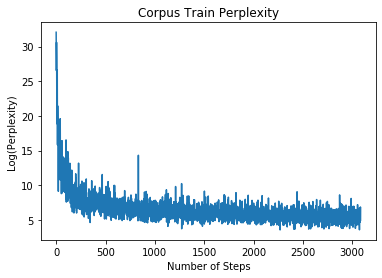

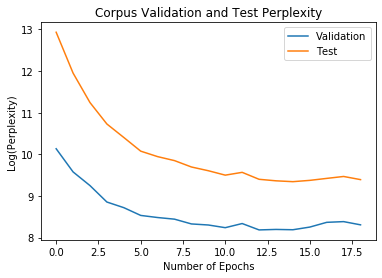

In [35]:
plt.plot(np.log(run01_perplexity_history[1:]))
plt.title('Corpus Train Perplexity')
plt.xlabel('Number of Steps')
plt.ylabel('Log(Perplexity)')
plt.show()

plt.plot(np.log(run01_val_perplexity_history[1:]))
plt.plot(np.log(run01_test_perplexity_history[1:]))
plt.title('Corpus Validation and Test Perplexity')
plt.xlabel('Number of Epochs')
plt.ylabel('Log(Perplexity)')
plt.legend(['Validation', 'Test'])
plt.show()

### Corpus Cost

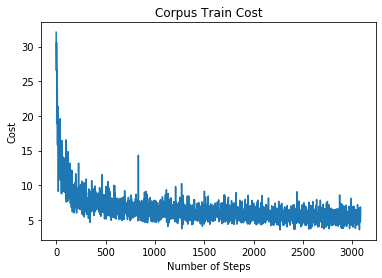

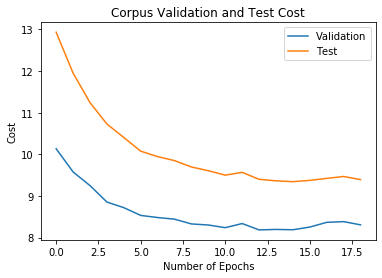

In [36]:
plt.plot(run01_cost_history[1:])
plt.title('Corpus Train Cost')
plt.xlabel('Number of Steps')
plt.ylabel('Cost')
plt.show()

plt.plot(run01_val_cost_history[1:])
plt.plot(run01_test_cost_history[1:])
plt.title('Corpus Validation and Test Cost')
plt.xlabel('Number of Epochs')
plt.ylabel('Cost')
plt.legend(['Validation', 'Test'])
plt.show()